# Medical Image Processing
### Final Project
### Mira Budenova

In [27]:
!pip install pydicom

In [208]:
# Importing the libraries
import os
import pydicom
import numpy as np
import scipy.ndimage
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import task1 as t1


In [2]:
# Loading the images and masks
reference_folder = 'C://Users//Amir//Downloads//RadCTTACEomics_1053-20250409T154823Z-001//RadCTTACEomics_1053//10_AP_Ax2.50mm'
tumor_path = 'C://Users//Amir//Downloads//RadCTTACEomics_1053-20250409T154823Z-001//RadCTTACEomics_1053//10_AP_Ax2.50mm_ManualROI_Tumor.dcm'
liver_path = 'C://Users//Amir//Downloads//RadCTTACEomics_1053-20250409T154823Z-001//RadCTTACEomics_1053//10_AP_Ax2.50mm_ManualROI_Liver.dcm'

### Task 1: Creating an animation with a rotating Maximum Intensity Projection on the coronal-sagittal planes, visualizing the tumoral mask.


In [203]:
ct_files, ct_volume, ct_z_positions = t1.load_images(reference_folder)

All slices are from a single acquisition.


In [210]:
tumor_mask, tumor_z_positions = t1.load_mask(tumor_path)
liver_mask, liver_z_positions = t1.load_mask(liver_path)

AttributeError: module 'task1' has no attribute 'load_mask'

In [209]:
tumor_mask_volume = t1.reorder_masks(ct_volume, tumor_mask, ct_z_positions, tumor_z_positions)
liver_mask_volume = t1.reorder_masks(ct_volume, liver_mask, ct_z_positions, liver_z_positions)

AttributeError: module 'task1' has no attribute 'reorder_masks'

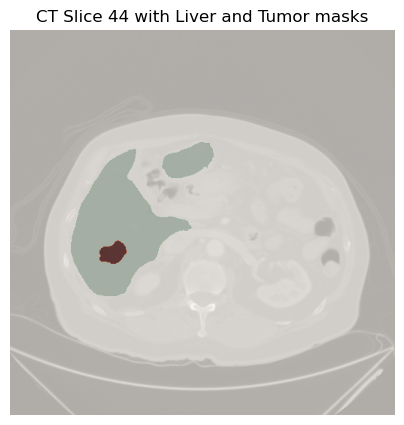

In [ ]:


t1.slice_overlay(ct_volume, liver_mask_volume, tumor_mask_volume, slice_idx=44)

In [ ]:


frames = t1.calculate_mip_coronal(ct_volume=ct_volume, tumor_mask_volume=tumor_mask_volume, liver_mask_volume=liver_mask_volume)

MovieWriter ffmpeg unavailable; using Pillow instead.


Saved results/MIP/rotating_coronal.gif


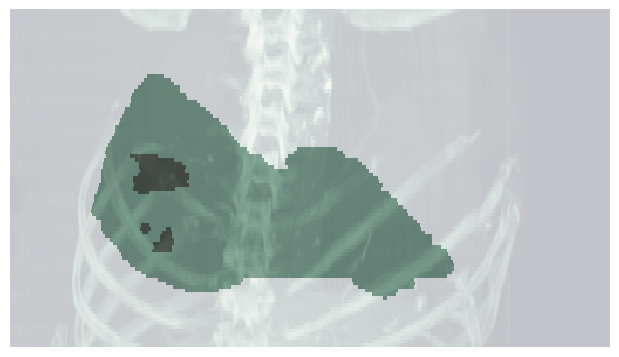

In [ ]:
img_min, img_max = np.min(ct_volume), np.max(ct_volume)
cm = plt.colormaps['bone']

# Computing slice thickness, pixel spacing, and pixel length for visualization
slice_thickness = abs(ct_z_positions[1] - ct_z_positions[0]) 
pixel_spacing_x, pixel_spacing_y = ct_files[0].PixelSpacing 
pixel_len_mm = [slice_thickness, pixel_spacing_y]

for idx, (rotated_ct, rotated_mask_tumor, rotated_mask_liver) in enumerate(frames):
    fig, ax = plt.subplots(figsize=(6, 4))
    
    ax.imshow(rotated_ct,
              cmap=cm,
              vmin=img_min, vmax=img_max,
              aspect=pixel_len_mm[0] / pixel_len_mm[1],
              interpolation='nearest')

    ax.imshow(rotated_mask_tumor,
              cmap='Reds',
              alpha=0.4,
              aspect=pixel_len_mm[0] / pixel_len_mm[1],
              interpolation='nearest')

    ax.imshow(rotated_mask_liver,
              cmap='Greens',
              alpha=0.4,
              aspect=pixel_len_mm[0] / pixel_len_mm[1],
              interpolation='nearest')

    ax.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(f'results/MIP/Frame_{idx:02d}.png', bbox_inches='tight')
    plt.close(fig)

# Producing animation
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
plt.tight_layout(pad=0)

animation_frames = []
for proj_ct, proj_mask_tumor, proj_mask_liver in frames:
    im_ct = ax.imshow(proj_ct,
                      cmap=cm,
                      vmin=img_min, vmax=img_max,
                      aspect=pixel_len_mm[0] / pixel_len_mm[1],
                      interpolation='nearest',
                      animated=True)

    im_mask_tumor = ax.imshow(proj_mask_tumor,
                              cmap='Reds',
                              alpha=0.4,
                              aspect=pixel_len_mm[0] / pixel_len_mm[1],
                              interpolation='nearest',
                              animated=True)

    im_mask_liver = ax.imshow(proj_mask_liver,
                              cmap='Greens',
                              alpha=0.4,
                              aspect=pixel_len_mm[0] / pixel_len_mm[1],
                              interpolation='nearest',
                              animated=True)

    animation_frames.append([im_ct, im_mask_tumor, im_mask_liver])

anim = animation.ArtistAnimation(
    fig,
    animation_frames,
    interval=100,
    blit=True
)

anim.save('results/MIP/rotating_MIP_coronal_new.gif')
print("Saved results/MIP/rotating_coronal.gif")


### Task 2. 3D Image Segmentation

In [24]:
# Function to get bounding box and centroid of the tumor
def get_bounding_box_and_centroid(mask: np.ndarray):
    # Getting coordinates of non-zero voxels - tumor
    coords = np.argwhere(mask > 0)

    if coords.size == 0:
        raise ValueError("No non-zero voxels found in the mask.")

    # Bounding box
    min_z, min_y, min_x = coords.min(axis=0)
    max_z, max_y, max_x = coords.max(axis=0)

    bbox = {
        'min': (min_z, min_y, min_x),
        'max': (max_z, max_y, max_x),
        'shape': (max_z - min_z + 1, max_y - min_y + 1, max_x - min_x + 1)
    }

    # Centroid
    centroid = coords.mean(axis=0)
    print(f"\n Bounding Box:")
    print(f"  Min: {bbox['min']}")
    print(f"  Max: {bbox['max']}")
    print(f"  Shape: {bbox['shape']}")

    print("\n Centroid (Z, Y, X):")
    print(centroid)
    return bbox, centroid

In [25]:
bbox_tumor, centroid_tumor = get_bounding_box_and_centroid(tumor_mask_volume)
bbox_liver, centroid_liver = get_bounding_box_and_centroid(liver_mask_volume)


 Bounding Box:
  Min: (40, 265, 105)
  Max: (66, 340, 156)
  Shape: (27, 76, 52)

 Centroid (Z, Y, X):
[ 46.91122747 298.53007793 134.22601072]

 Bounding Box:
  Min: (18, 146, 74)
  Max: (79, 359, 360)
  Shape: (62, 214, 287)

 Centroid (Z, Y, X):
[ 54.96733176 243.67789759 181.28325049]


### Check and edit

In [26]:
# Function to implement region growing algorithm on CT slices
def region_growing_bounding_box(ct_volume: np.ndarray, seed: tuple, bbox: dict, threshold: float = 5.0) -> np.ndarray:
  
    # Calculating the seed intensity to use for finding the tumor (based on the difference using threshold)
    z_dim, y_dim, x_dim = ct_volume.shape
    seed_z, seed_y, seed_x = map(int, seed)
    seed_intensity = ct_volume[seed_z, seed_y, seed_x]
    
    # Bounding box limits
    z_min, y_min, x_min = bbox['min']
    z_max, y_max, x_max = bbox['max']
    
    visited = np.zeros_like(ct_volume, dtype=bool)
    mask = np.zeros_like(ct_volume, dtype=np.uint8)
    
    queue = deque()
    queue.append((seed_z, seed_y, seed_x))
    visited[seed_z, seed_y, seed_x] = True

    while queue:
        z, y, x = queue.popleft()
        
        # Checking if voxel is inside bounding box
        if not (z_min <= z <= z_max and y_min <= y <= y_max and x_min <= x <= x_max):
            continue
        
        current_intensity = ct_volume[z, y, x]
        
        if abs(current_intensity - seed_intensity) <= threshold:
            mask[z, y, x] = 1
            
            # 6-connectivity neighbors
            for dz, dy, dx in [(-1,0,0),(1,0,0),(0,-1,0),(0,1,0),(0,0,-1),(0,0,1)]:
                nz, ny, nx = z+dz, y+dy, x+dx
                if 0 <= nz < z_dim and 0 <= ny < y_dim and 0 <= nx < x_dim:
                    if not visited[nz, ny, nx]:
                        visited[nz, ny, nx] = True
                        queue.append((nz, ny, nx))
    
    return mask

In [166]:
predicted_mask = region_growing_bounding_box(ct_volume, seed=centroid_tumor, bbox=bbox_tumor, threshold=36.0)
# View nonzero voxel count
print("Predicted tumor voxels:", np.count_nonzero(predicted_mask))

Predicted tumor voxels: 3433


### Don't use this for now (segmentation using centroid)

In [43]:
def region_growing(ct_volume: np.ndarray, seed: tuple, threshold: float = 5.0) -> np.ndarray:

    z_dim, y_dim, x_dim = ct_volume.shape
    seed_z, seed_y, seed_x = map(int, seed)
    seed_intensity = ct_volume[seed_z, seed_y, seed_x]
    
    visited = np.zeros_like(ct_volume, dtype=bool)
    mask = np.zeros_like(ct_volume, dtype=np.uint8)
    
    queue = deque()
    queue.append((seed_z, seed_y, seed_x))
    visited[seed_z, seed_y, seed_x] = True

    while queue:
        z, y, x = queue.popleft()
        current_intensity = ct_volume[z, y, x]
        
        if abs(current_intensity - seed_intensity) <= threshold:
            mask[z, y, x] = 1
            
            # 6-connectivity: check neighbors
            for dz, dy, dx in [(-1,0,0),(1,0,0),(0,-1,0),(0,1,0),(0,0,-1),(0,0,1)]:
                nz, ny, nx = z+dz, y+dy, x+dx
                if 0 <= nz < z_dim and 0 <= ny < y_dim and 0 <= nx < x_dim:
                    if not visited[nz, ny, nx]:
                        visited[nz, ny, nx] = True
                        queue.append((nz, ny, nx))
    
    return mask

In [44]:
# Assuming you have CT volume and centroid from previous step
predicted_mask = region_growing(ct_volume, seed=centroid_tumor, threshold=5.0)

# View nonzero voxel count
print("Predicted tumor voxels:", np.count_nonzero(predicted_mask))

Predicted tumor voxels: 1


### Visualisation

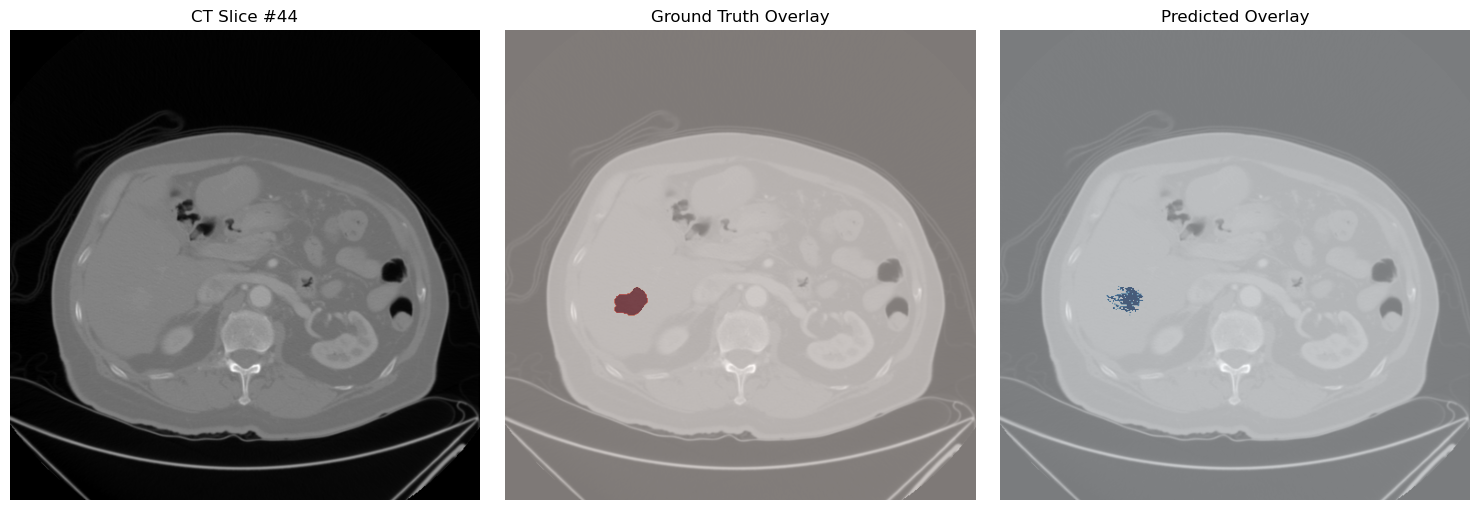

In [167]:
# Function to show the result of segmentation on slices
def show_segmentation(ct_volume, true_mask, pred_mask, slice_index=None):
    if slice_index is None:
        slice_index = np.mean(np.argwhere(true_mask > 0)[:, 0]).astype(int)

    ct_slice = ct_volume[slice_index]
    gt_slice = true_mask[slice_index]
    pred_slice = pred_mask[slice_index]

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(ct_slice, cmap='gray')
    ax[0].set_title(f"CT Slice #{slice_index}")

    ax[1].imshow(ct_slice, cmap='gray')
    ax[1].imshow(gt_slice, alpha=0.5, cmap='Reds')
    ax[1].set_title("Ground Truth Overlay")

    ax[2].imshow(ct_slice, cmap='gray')
    ax[2].imshow(pred_slice, alpha=0.5, cmap='Blues')
    ax[2].set_title("Predicted Overlay")

    for a in ax:
        a.axis('off')

    plt.tight_layout()
    plt.show()

show_segmentation(ct_volume, tumor_mask_volume, predicted_mask, 44)

In [168]:

def region_growing_3d(ct_volume: np.ndarray, seed: tuple, bbox: dict = None, threshold: float = 5.0) -> np.ndarray:

    z_dim, y_dim, x_dim = ct_volume.shape
    seed_z, seed_y, seed_x = map(int, seed)
    seed_intensity = ct_volume[seed_z, seed_y, seed_x]
    
    # Bounding box limits (if provided)
    if bbox:
        z_min, y_min, x_min = bbox['min']
        z_max, y_max, x_max = bbox['max']
    else:
        z_min, y_min, x_min, z_max, y_max, x_max = 0, 0, 0, z_dim-1, y_dim-1, x_dim-1

    visited = np.zeros_like(ct_volume, dtype=bool)
    mask = np.zeros_like(ct_volume, dtype=np.uint8)
    
    queue = deque()
    queue.append((seed_z, seed_y, seed_x))
    visited[seed_z, seed_y, seed_x] = True

    while queue:
        z, y, x = queue.popleft()
        
        # Skip points outside the bounding box
        if not (z_min <= z <= z_max and y_min <= y <= y_max and x_min <= x <= x_max):
            continue
        
        current_intensity = ct_volume[z, y, x]
        
        # Check if intensity is within threshold
        if abs(current_intensity - seed_intensity) <= threshold:
            mask[z, y, x] = 1
            
            # 26-connectivity neighbors (all adjacent points in 3D)
            for dz, dy, dx in [(-1,0,0),(1,0,0),(0,-1,0),(0,1,0),(0,0,-1),(0,0,1),
                                 (-1,-1,0),(-1,1,0),(1,-1,0),(1,1,0),
                                 (0,-1,-1),(0,-1,1),(0,1,-1),(0,1,1),
                                 (-1,0,-1),(-1,0,1),(1,0,-1),(1,0,1)]:
                nz, ny, nx = z + dz, y + dy, x + dx
                if 0 <= nz < z_dim and 0 <= ny < y_dim and 0 <= nx < x_dim:
                    if not visited[nz, ny, nx]:
                        visited[nz, ny, nx] = True
                        queue.append((nz, ny, nx))
    
    return mask

segmented_mask_3d = region_growing_3d(ct_volume, seed=centroid_tumor, bbox=bbox_tumor, threshold=36.0)
print("Segmented voxels count:", np.count_nonzero(segmented_mask_3d))

Segmented voxels count: 3784


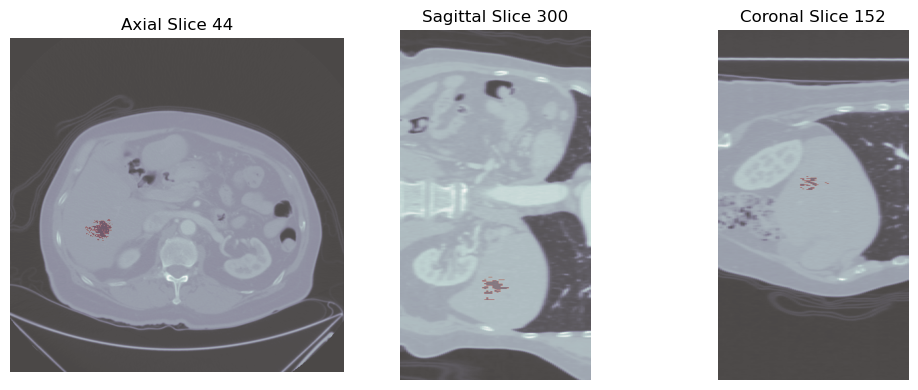

In [169]:
def show_slices_zoomed(ct_volume, segmentation_mask, slice_indices=None, zoom_factor=3):
    """Shows slices with controlled zoom on sagittal view"""
    if slice_indices is None:
        slice_indices = [ct_volume.shape[0]//2, ct_volume.shape[1]//2, ct_volume.shape[2]//2]
    
    fig = plt.figure(figsize=(10, 4))
    
    # Axial
    ax1 = fig.add_subplot(131)
    ax1.imshow(ct_volume[slice_indices[0]], cmap='bone')
    ax1.imshow(segmentation_mask[slice_indices[0]], cmap='Reds', alpha=0.3)
    ax1.set_title(f'Axial Slice {slice_indices[0]}')
    
    # Sagittal with zoom control
    ax2 = fig.add_subplot(132)
    sag_ct = np.flipud(ct_volume[:, slice_indices[1], :].swapaxes(0, 1))
    sag_seg = np.flipud(segmentation_mask[:, slice_indices[1], :].swapaxes(0, 1))
    ax2.imshow(sag_ct, cmap='bone', aspect=1/zoom_factor)
    ax2.imshow(sag_seg, cmap='Reds', alpha=0.3, aspect=1/zoom_factor)
    ax2.set_title(f'Sagittal Slice {slice_indices[1]}')
    
    # Coronal
    ax3 = fig.add_subplot(133)
    cor_ct = np.flipud(ct_volume[:, :, slice_indices[2]].swapaxes(0, 1))
    cor_seg = np.flipud(segmentation_mask[:, :, slice_indices[2]].swapaxes(0, 1))
    ax3.imshow(cor_ct, cmap='bone', aspect=1/zoom_factor)
    ax3.imshow(cor_seg, cmap='Reds', alpha=0.3, aspect=1/zoom_factor, vmin=0, vmax=1)
    #ax3.imshow(ct_volume[:, :, slice_indices[2]], cmap='gray')
    #ax3.imshow(segmentation_mask[:, :, slice_indices[2]], cmap='Reds', alpha=0.3)
    ax3.set_title(f'Coronal Slice {slice_indices[2]}')
    
    for ax in [ax1, ax2, ax3]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Usage (try zoom factors between 2-5)
show_slices_zoomed(ct_volume, segmented_mask_3d, [44, 300, 152], zoom_factor=3)

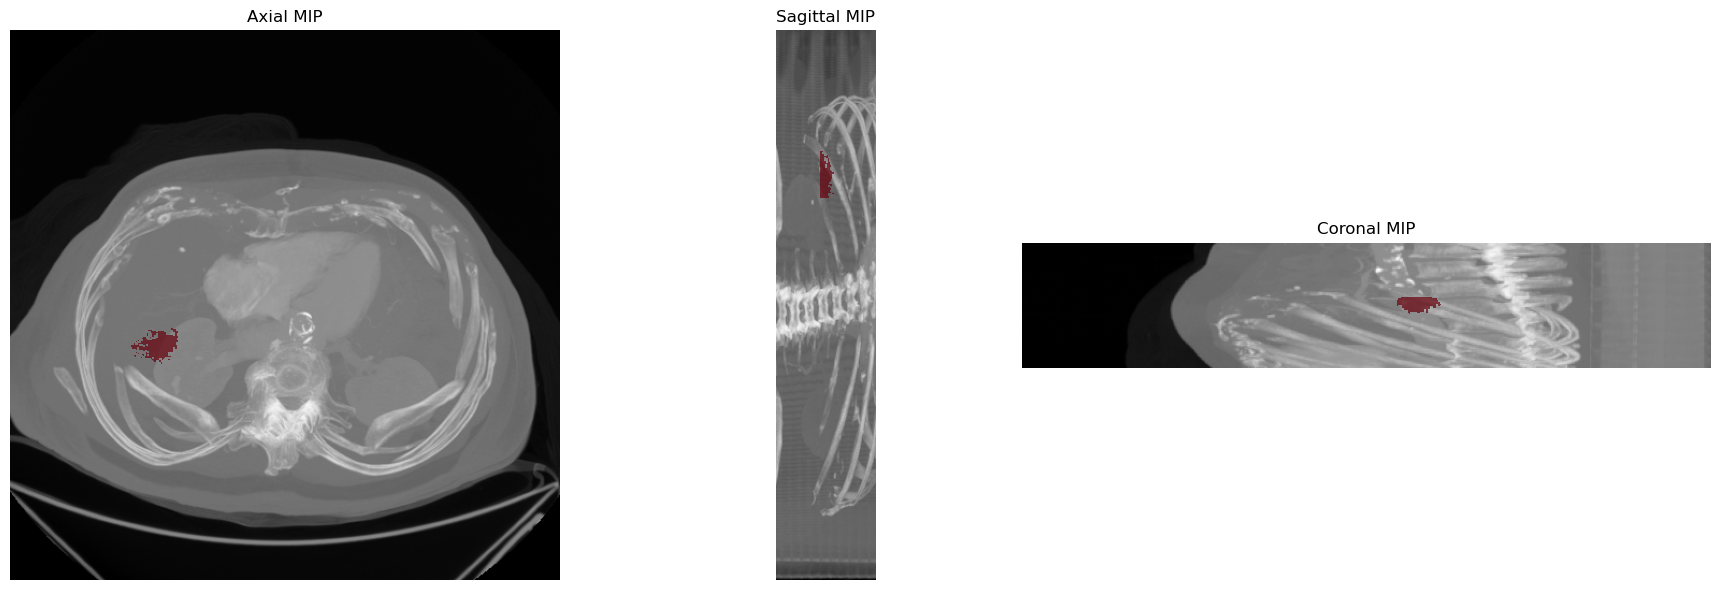

In [170]:
def show_mip_views(ct_volume, segmentation_mask):
    """
    Shows MIP views with clear segmentation overlay
    
    Parameters:
        ct_volume: 3D CT volume (normalized to 0-1)
        segmentation_mask: 3D binary mask (0=background, 1=tumor)
        contrast_window: (window_level, window_width) for CT display
    """
    # Calculate MIPs
    mip_axial = np.max(ct_volume, axis=0)
    mip_sagittal = np.max(ct_volume, axis=1)
    mip_coronal = np.max(ct_volume, axis=2)
    
    # Calculate segmentation MIPs
    seg_mip_axial = np.max(segmentation_mask, axis=0)
    seg_mip_sagittal = np.max(segmentation_mask, axis=1)
    seg_mip_coronal = np.max(segmentation_mask, axis=2)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Axial MIP
    axes[0].imshow(mip_axial, cmap='gray')
    axes[0].imshow(np.ma.masked_where(seg_mip_axial == 0, seg_mip_axial), 
                  cmap='Reds', alpha=0.7, vmin=0, vmax=1)
    axes[0].set_title('Axial MIP')
    
    # Sagittal MIP (transposed for correct orientation)
    axes[1].imshow(mip_sagittal.T, cmap='gray')
    axes[1].imshow(np.ma.masked_where(seg_mip_sagittal.T == 0, seg_mip_sagittal.T), 
                  cmap='Reds', alpha=0.7, vmin=0, vmax=1)
    axes[1].set_title('Sagittal MIP')
    
    # Coronal MIP
    axes[2].imshow(mip_coronal, cmap='gray')
    axes[2].imshow(np.ma.masked_where(seg_mip_coronal == 0, seg_mip_coronal), 
                  cmap='Reds', alpha=0.7, vmin=0, vmax=1)
    axes[2].set_title('Coronal MIP')
    
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Basic usage
show_mip_views(ct_volume, segmented_mask_3d)

In [ ]:
# Numerical Evaluation
from sklearn.metrics import (accuracy_score, f1_score, 
                            precision_score, recall_score,
                            jaccard_score)

def evaluate_segmentation(ground_truth, predicted_mask, verbose=True):

    # Flatten arrays for sklearn metrics
    gt_flat = ground_truth.flatten()
    pred_flat = predicted_mask.flatten()
    
    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(gt_flat, pred_flat),
        'F1': f1_score(gt_flat, pred_flat),
        'Precision': precision_score(gt_flat, pred_flat),
        'Recall/Sensitivity': recall_score(gt_flat, pred_flat),
        'Specificity': recall_score(gt_flat, pred_flat, pos_label=0),
        'IoU/Jaccard': jaccard_score(gt_flat, pred_flat),
        'Dice': f1_score(gt_flat, pred_flat),  # Dice = F1 for binary
        'False_Positive_Rate': 1 - recall_score(gt_flat, pred_flat, pos_label=0)
    }
    
    if verbose:
        print("\nSegmentation Evaluation Metrics:")
        print("-" * 40)
        for name, value in metrics.items():
            print(f"{name:<20}: {value:.4f}")
        
        # Print confusion matrix
        print("\nConfusion Matrix (True vs Predicted):")
        print(np.bincount(2 * gt_flat + pred_flat, minlength=4).reshape(2, 2))
    
    return metrics

# Usage example (if you have ground truth data)
metrics = evaluate_segmentation(tumor_mask_volume, segmented_mask_3d)


Segmentation Evaluation Metrics:
----------------------------------------
Accuracy            : 0.9998
F1                  : 0.5033
Precision           : 0.7978
Recall/Sensitivity  : 0.3676
Specificity         : 1.0000
IoU/Jaccard         : 0.3363
Dice                : 0.5033
False_Positive_Rate : 0.0000

Confusion Matrix (True vs Predicted):
[[24370415      765]
 [    5193     3019]]


### Other segmentation options

In [197]:


from skimage.segmentation import flood_fill
from skimage.measure import label
import numpy as np

def segment_tumor_region_growing(ct_volume, seed_point, bbox, tolerance=36):
    """Robust region growing with bounds checking"""
    seed_z, seed_y, seed_x = map(int, seed_point)  # Ensure integer coordinates
    z_min, y_min, x_min = map(int, bbox['min'])    # Convert bbox to integers
    z_max, y_max, x_max = map(int, bbox['max'])
    
    # Verify seed is within bounding box
    if not (z_min <= seed_z < z_max and 
            y_min <= seed_y < y_max and 
            x_min <= seed_x < x_max):
        raise ValueError("Seed point is outside the bounding box")
    
    # Extract ROI and ensure it's a copy
    roi = np.array(ct_volume[z_min:z_max, y_min:y_max, x_min:x_max], copy=True)
    
    # Calculate relative seed position within ROI
    seed_rel = (seed_z - z_min, seed_y - y_min, seed_x - x_min)
    
    # Get seed value (with bounds check)
    try:
        seed_value = roi[seed_rel]
    except IndexError as e:
        raise IndexError(f"Relative seed position {seed_rel} is invalid for ROI shape {roi.shape}") from e
    
    # Perform flood fill
    filled = flood_fill(
        roi, 
        seed_point=seed_rel,
        new_value=-1,  # Temporary fill value
        tolerance=tolerance,
        connectivity=3  # 3D connectivity
    )
    
    # Create binary mask from filled region
    binary = (filled == -1)
    
    # Keep only the largest connected component
    labeled = label(binary)
    if labeled.max() == 0:  # No regions found
        return np.zeros_like(ct_volume, dtype=np.uint8)
    
    # Get sizes of all components except background (0)
    component_sizes = np.bincount(labeled.flat)[1:]
    largest_component = np.argmax(component_sizes) + 1
    
    # Create final mask
    roi_mask = (labeled == largest_component)
    
    # Map back to original volume space
    full_mask = np.zeros_like(ct_volume, dtype=np.uint8)
    full_mask[z_min:z_max, y_min:y_max, x_min:x_max] = roi_mask
    
    return full_mask

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

def segment_tumor_watershed(ct_volume, bbox, seed_point):
    """Watershed segmentation within bounding box"""
    seed_z, seed_y, seed_x = map(int, seed_point)
    z_min, y_min, x_min = bbox['min']
    z_max, y_max, x_max = bbox['max']
    roi = ct_volume[z_min:z_max, y_min:y_max, x_min:x_max]
    
    # Compute distance transform
    threshold = np.percentile(roi, 2.7)
    binary = roi > threshold
    distance = ndi.distance_transform_edt(binary)
    
    # Find markers
    coords = peak_local_max(distance, footprint=np.ones((3,3,3)), labels=binary)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers = label(mask)
    
    # Apply watershed
    labels = watershed(-distance, markers, mask=binary)
    
    # Select region containing seed point
    seed_rel = (seed_z-z_min, seed_y-y_min, seed_x-x_min)
    target_label = labels[seed_rel]
    tumor_mask = (labels == target_label)
    
    full_mask = np.zeros_like(ct_volume, dtype=np.uint8)
    full_mask[z_min:z_max, y_min:y_max, x_min:x_max] = tumor_mask
    
    return full_mask

In [172]:
def compare_segmentations(ct_volume, masks_dict, slice_idx):
    """Compare multiple segmentation methods on one slice"""
    plt.figure(figsize=(15, 5))
    
    # Original CT
    ct_slice = ct_volume[slice_idx]
    liver_slice = liver_mask_volume[slice_idx]
    tumor_slice = tumor_mask_volume[slice_idx]
    plt.subplot(1, len(masks_dict)+1, 1)
    plt.imshow(ct_slice, cmap='gray')
    plt.imshow(liver_slice, cmap='Greens', alpha=0.4)
    plt.imshow(tumor_slice, cmap='Reds', alpha=0.5) 
    plt.title(f'CT Slice {slice_idx} with Liver and Tumor masks')
    
    # Each segmentation method
    for i, (name, mask) in enumerate(masks_dict.items(), 2):
        plt.subplot(1, len(masks_dict)+1, i)
        plt.imshow(ct_volume[slice_idx], cmap='gray')
        plt.imshow(mask[slice_idx], cmap='Reds', alpha=0.5)
        plt.title(name)
    
    plt.tight_layout()
    plt.show()

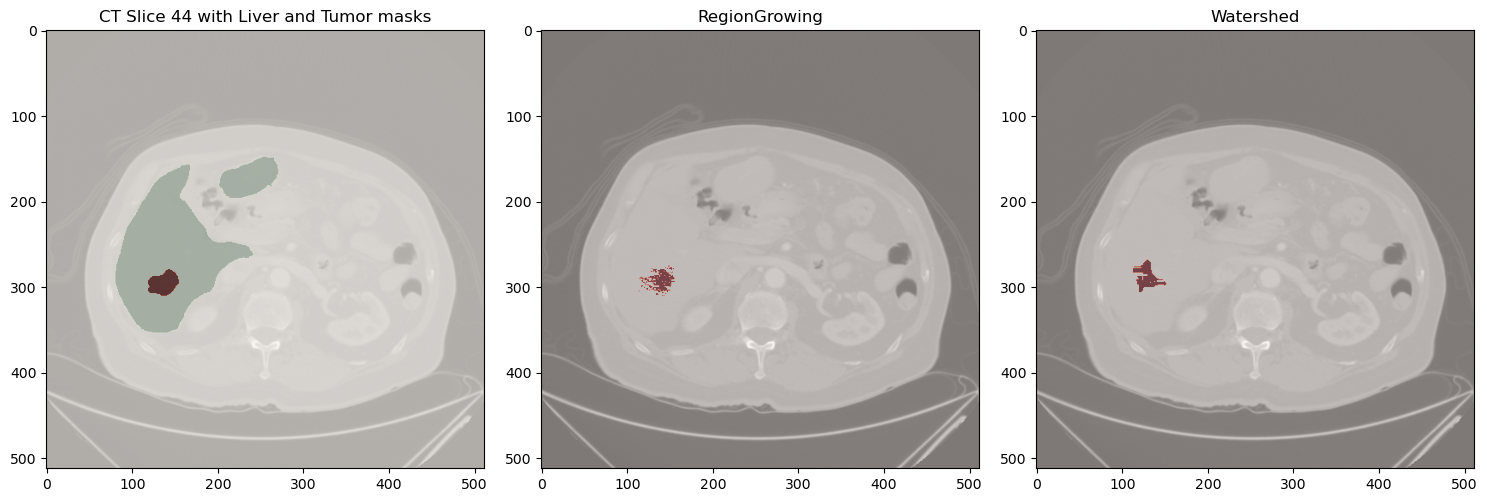

In [198]:
# Try all methods
methods = {
    'RegionGrowing': segment_tumor_region_growing(ct_volume, centroid_tumor, bbox_tumor, tolerance=36),
    'Watershed': segment_tumor_watershed(ct_volume, bbox_tumor, centroid_tumor)
}

# Visualize results at middle slice
compare_segmentations(ct_volume, methods, slice_idx=44)

### Numerical Evaluation


Segmentation Performance Comparison:
--------------------------------------------------

Method: RegionGrowing
Dice        : 0.5015
IoU         : 0.3347
Precision   : 0.7842
Recall      : 0.3686
Accuracy    : 0.9998
Specificity : 1.0000

Method: Watershed
Dice        : 0.4100
IoU         : 0.2578
Precision   : 0.5026
Recall      : 0.3462
Accuracy    : 0.9997
Specificity : 0.9999


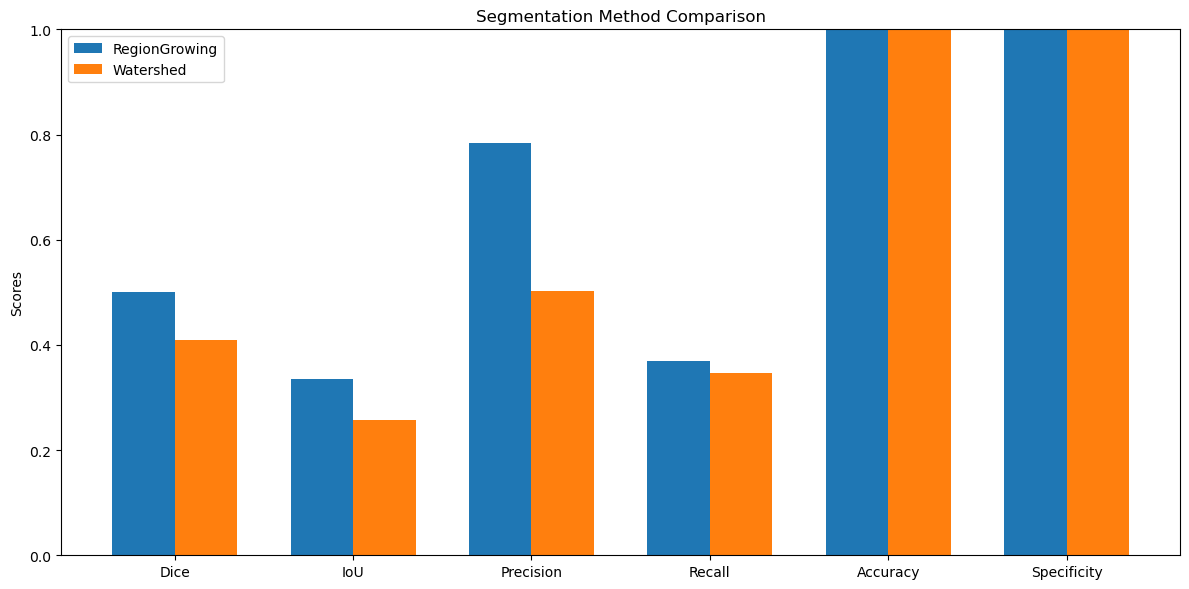

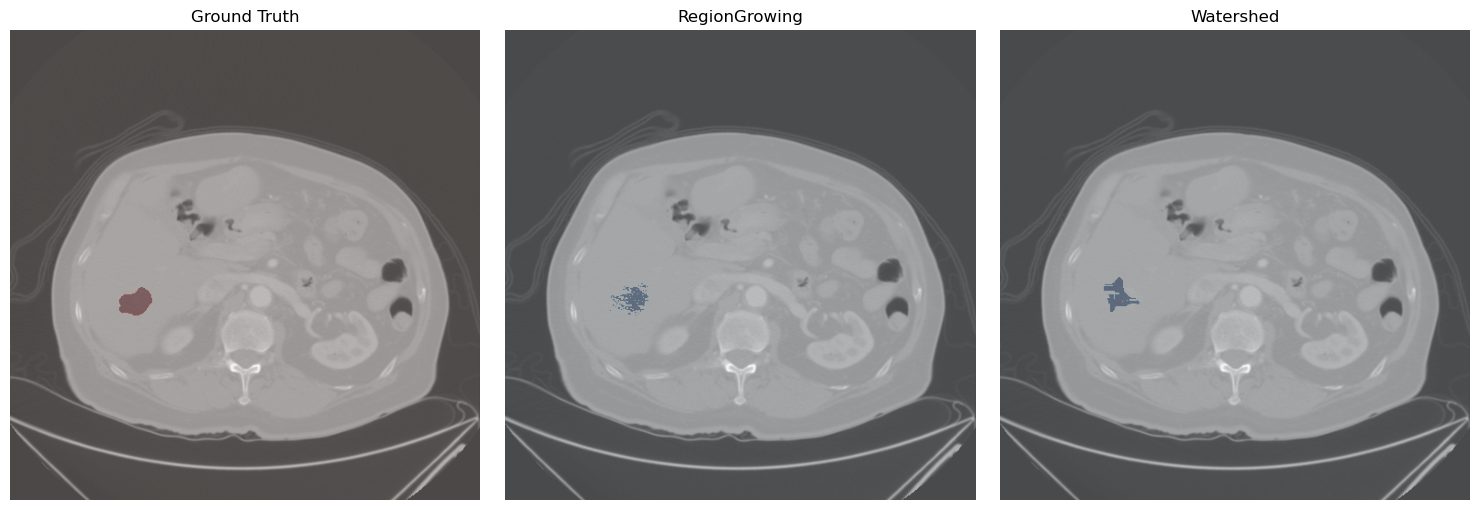

In [200]:
import numpy as np
from sklearn.metrics import (accuracy_score, f1_score, precision_score, 
                            recall_score, jaccard_score)
import matplotlib.pyplot as plt

# 1. First ensure you have ground truth data loaded
gt_mask = tumor_mask_volume  # This should be a 3D numpy array with same dimensions as ct_volume

# 3. Evaluation function
def evaluate_methods(gt_mask, methods_dict):
    """Evaluate multiple segmentation methods against ground truth"""
    results = {}
    
    for method_name, pred_mask in methods_dict.items():
        # Ensure masks are binary and have same shape
        pred_binary = (pred_mask > 0).astype(np.uint8)
        gt_binary = (gt_mask > 0).astype(np.uint8)
        
        assert pred_binary.shape == gt_binary.shape, "Masks must have same dimensions"
        
        # Calculate metrics
        results[method_name] = {
            'Dice': f1_score(gt_binary.flatten(), pred_binary.flatten()),
            'IoU': jaccard_score(gt_binary.flatten(), pred_binary.flatten()),
            'Precision': precision_score(gt_binary.flatten(), pred_binary.flatten()),
            'Recall': recall_score(gt_binary.flatten(), pred_binary.flatten()),
            'Accuracy': accuracy_score(gt_binary.flatten(), pred_binary.flatten()),
            'Specificity': recall_score(gt_binary.flatten(), pred_binary.flatten(), pos_label=0)
        }
    
    return results

# 4. Run evaluation
evaluation_results = evaluate_methods(gt_mask, methods)

# 5. Print results
print("\nSegmentation Performance Comparison:")
print("-" * 50)
for method, metrics in evaluation_results.items():
    print(f"\nMethod: {method}")
    for metric, value in metrics.items():
        print(f"{metric:<12}: {value:.4f}")

# 6. Visual comparison
def plot_metrics_comparison(results):
    metrics = list(results[next(iter(results))].keys())
    methods = list(results.keys())
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    for i, method in enumerate(methods):
        values = [results[method][m] for m in metrics]
        ax.bar(x + i*width, values, width, label=method)
    
    ax.set_ylabel('Scores')
    ax.set_title('Segmentation Method Comparison')
    ax.set_xticks(x + width/2)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.show()

plot_metrics_comparison(evaluation_results)

# 7. Slice-by-slice visualization (optional)
def show_comparison_slices(gt_mask, methods_dict, slice_idx):
    """Visual comparison on specific slice"""
    plt.figure(figsize=(15, 5))
    
    # Ground truth
    plt.subplot(1, len(methods_dict)+1, 1)
    plt.imshow(ct_volume[slice_idx], cmap='gray')
    plt.imshow(gt_mask[slice_idx], cmap='Reds', alpha=0.3)
    plt.title('Ground Truth')
    plt.axis('off')
    
    # Each method
    for i, (name, mask) in enumerate(methods_dict.items(), 2):
        plt.subplot(1, len(methods_dict)+1, i)
        plt.imshow(ct_volume[slice_idx], cmap='gray')
        plt.imshow(mask[slice_idx], cmap='Blues', alpha=0.3)
        plt.title(name)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show middle slice comparison
show_comparison_slices(gt_mask, methods, slice_idx=44)